In [55]:
!pip install imbalanced-learn

캐글 신용카드 거래내용이 포함된 데이터 셋을 아래 사이트에서 다운받아 다음 사항을 수행하세요.

https://www.kaggle.com/mlg-ulb/creditcardfraud

데이터 설명
데이터 세트에는 유럽 카드 소지자가 2013년 9월에 신용 카드로 거래한 내용이 포함되어 있습니다. 이 데이터 세트는 284,807건의 거래 중 492건의 사기가 발생한 이틀 동안 발생한 거래를 보여줍니다. 데이터 세트는 매우 불균형하며 긍정적 클래스(사기)는 모든 거래의 0.172%를 차지합니다.

여기에는 PCA 변환의 결과인 숫자 입력 변수만 포함됩니다. 안타깝게도 기밀 문제로 인해 데이터에 대한 원래 기능과 추가 배경 정보를 제공할 수 없습니다. 기능 V1, V2, … V28은 PCA로 얻은 주요 구성 요소이며 PCA로 변환되지 않은 유일한 기능은 '시간'과 '양'입니다. 기능 '시간'에는 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 초가 포함됩니다. 'Amount' 기능은 거래 금액이며, 이 기능은 예제 종속 비용에 민감한 학습에 사용할 수 있습니다. 기능 'Class'는 응답 변수이며 사기의 경우 값 1, 그렇지 않은 경우 0을 취합니다.

 - 데이터 전처리 후 로지스틱 리그레션을 적용한 모델 학습 및 평가(정확도, 정밀도, 재현율, F1 score, AUC)
 - Amount 피처를 정규분포 및 로그 변환 후 모델 학습 및 평가
 - 상관성이 높은 피처 한개를 선택하여 이상치 데이터 제거 후 모델 학습 및 평가
 - SMOTE 오버 샘플링 적용 후 모델 학습 및 평가
 - SMOTE 적용 시 인사이트 요약

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('./dataset/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [57]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time',axis=1, inplace=True)
    return df_copy

In [58]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train,y_test= \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test,y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [59]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


[과제 1]로지스틱 회귀를 이용하여 신용카드 사기 여부를 예측
 - 성능평가 : get_clf_eval() 함수를 사용

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1_score: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [61]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

# get_clf_eval() 함수를 사용하여 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   61    87]]
정확도: 0.9991, 정밀도: 0.8788, 재현율: 0.5878,    F1_score: 0.7045, AUC:0.9548


LightGBM을 이용한 모델

In [62]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

LightGBM으로 모델을 학습한 뒤, 별도의 테스트 데이터 세트에서 예측 평가를 수행

In [63]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=True)
get_model_train_eval(lgbm_clf,ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85195   100]
 [   74    74]]
정확도: 0.9980, 정밀도: 0.4253, 재현율: 0.5000,    F1_score: 0.4596, AUC:0.7493


### 데이터 분포

 Amount 피처는 신용카드 사용금액으로 정상/사기 트랙젝션을 결정하는 매우 중요한 속성을 나타낼 가능성이 높다.

<AxesSubplot:xlabel='Amount', ylabel='Density'>

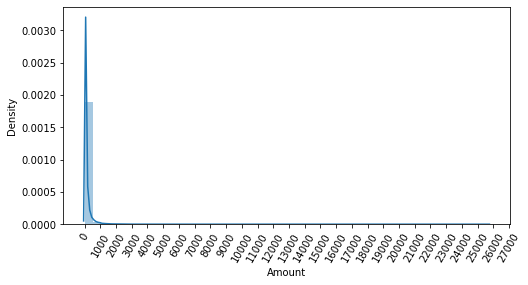

In [64]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

1000 불 이하인 데이터가 대부분이며, 최대 26000불까지 사용한 경우가 있다.

[과제-2] Amount 피처를 정규분포 및 로그 변환 후 모델 학습 및 평가

In [65]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))

    df_copy.insert(0, 'Amount_scaled', amount_n)
    
    df_copy.drop(['Time','Amount'],axis=1, inplace=True)
    return df_copy
    
    

In [66]:

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('LightGBM 예측성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1_score: 0.7143, AUC:0.9702
LightGBM 예측성능
오차 행렬
[[85248    47]
 [   69    79]]
정확도: 0.9986, 정밀도: 0.6270, 재현율: 0.5338,    F1_score: 0.5766, AUC:0.7666


로그변환을 수행

로그변환: 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나.
 - 로그변환은 numpy의 log1p()함수를 이용한다
 - 여기서는 데이터 가공 함수인 get_preprocessed_df()를 이용한다

In [67]:
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_scaled',amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

Amount 피처를 로그 변환한 후 다시 로지스틱 회귀와 LightGBM모델을 적용하여 예측 성능을 확인

In [68]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
get_model_train_eval(lr_clf,ftr_train=X_train, ftr_test=X_test, tgt_train = y_train, tgt_test=y_test)

print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1_score: 0.7149, AUC:0.9727
LightGBM 예측 성능
오차 행렬
[[85174   121]
 [  148     0]]
정확도: 0.9969, 정밀도: 0.0000, 재현율: 0.0000,    F1_score: 0.0000, AUC:0.4992


상관성이 높은 피처 한개를 선택하여 이상치 데이터 제거 후 모델 학습 및 평가

 이상치 데이터(Outlier) : 전체 데이터의 패턴에서 벗어난 이상값을 가진 데이터
  
 - IQR(inter quantile range) : 사분위값의 편차를 이용하는 기법으로 흔히 박스 플롯방식으로 시각화 할 수 있다.
 
 - IQR을 이용해 이상치를 검출하는 방식은 IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는 것이다.
 
 - 피처가 많을 경우 이들 중 결정값(레이블)과 가장 상관성이 높은 피처들을 위주로 이상치를 검출하는것이 좋음

<AxesSubplot:>

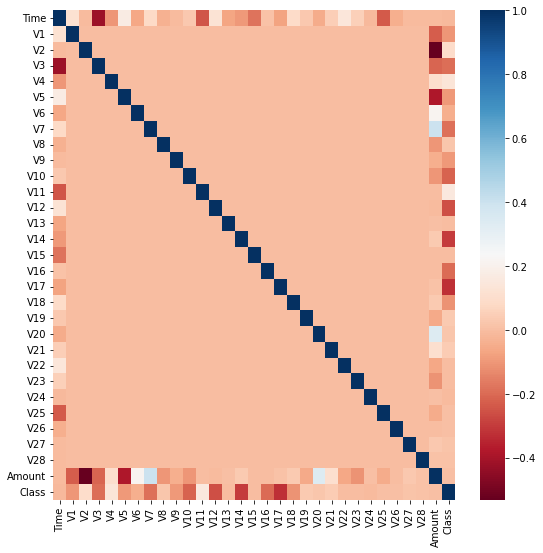

In [69]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr,cmap='RdBu')

양의 상관관계가 높을수록 색깔이 진한 파란색에 가까우며, 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가까이 표현된다.

In [70]:
# 맨 아래에 위치한 결정 레이블인 class feature와 음의 상관과계가 가장 높은 feature은 V14와 V17이다.

In [71]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [72]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [73]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print(' 로지스틱 회귀 예측 성능 ')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print(' LightGBM 예측 성능 ')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

 로지스틱 회귀 예측 성능 
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1_score: 0.7597, AUC:0.9743
 LightGBM 예측 성능 
오차 행렬
[[85268    27]
 [   36   110]]
정확도: 0.9993, 정밀도: 0.8029, 재현율: 0.7534,    F1_score: 0.7774, AUC:0.9219


이상치 데이터를 제거한 뒤에 로지스틱 회귀와 LightGBM 모두 예측성능이 향상됨
 
 (로지스틱 회귀 재현율: 60.81% -> 67.12%, LightGBM 재현율: 76.35% -> 82.88%)

[과제-4] SMOTE 오버 샘플링 적용 후 모델 학습 및 평가

  SMOTE기법 : SMOTE의 동작 방식은 데이터의 개수가 적은 클래스의 표본을 가져온 뒤 임의의 값을 추가하여 새로운 샘플을 만들어 데이터에 추가  하는 오버샘플링 방식이다.
       
  - SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링을 해야함
  - (검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링할 경우 원본 데이터 세트가 
  -  아닌 데이터 세트에서 검증 또는 테스트를 수행하기 때문에 올바른 테스트가 될 수 없기 때문)

https://john-analyst.medium.com/smote%EB%A1%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%88%EA%B7%A0%ED%98%95-%ED%95%B4%EA%B2%B0%ED%95%98%EA%B8%B0-5ab674ef0b32

In [74]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


 적용전 데이터와 적용후 데이터의 세트에서 2배 정도의 차이가 발생함(2배정도 증가함)
 
 SMOTE 적용후 레이블값의 0과 1의 분포가 동일하게 됨

In [75]:
# 로지스틱 회귀 모델을 학습한 뒤 성능을 평가

In [76]:
lr_clf = LogisticRegression()

get_model_train_eval(lr_clf,ftr_train= X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1_score: 0.1023, AUC:0.9737


In [77]:
# 로지스틱 회귀 모델에서 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가함

In [81]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

In [85]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(10,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0: threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('threshold value');plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()

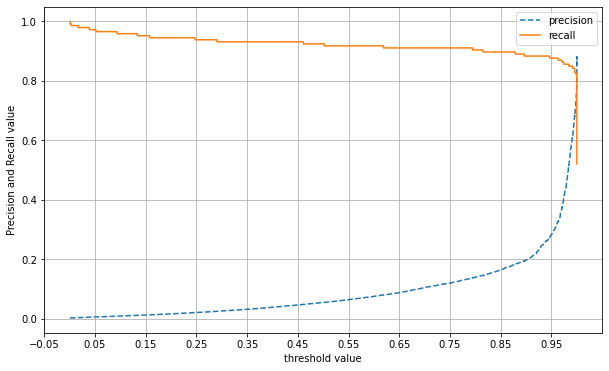

In [86]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [88]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=True)
get_model_train_eval(lgbm_clf,ftr_train=X_train_over, ftr_test= X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1_score: 0.8794, AUC:0.9814


 재현율은 
    이상치만 제거한 경우(LightGBM 예측 성능)인 82.88% 보다 높은 84.93%가 되었음.
 
 정밀도는
    이전의 96.8%보다 낮은 91.18%가 되었음.
    
 즉, SMOTE를 적용하면 재현율은 높아지나 정밀도는 낮아진다는걸 알 수 있다.
 효과적으로 데이터를 증식한다